# Noah Cina D209 Performance Assessment

## Task 2

         CaseOrder           Zip           Lat           Lng     Population  \
count  10000.00000  10000.000000  10000.000000  10000.000000   10000.000000   
mean    5000.50000  49153.319600     38.757567    -90.782536    9756.562400   
std     2886.89568  27532.196108      5.437389     15.156142   14432.698671   
min        1.00000    601.000000     17.966120   -171.688150       0.000000   
25%     2500.75000  26292.500000     35.341828    -97.082812     738.000000   
50%     5000.50000  48869.500000     39.395800    -87.918800    2910.500000   
75%     7500.25000  71866.500000     42.106908    -80.088745   13168.000000   
max    10000.00000  99929.000000     70.640660    -65.667850  111850.000000   

         Children           Age         Income  Outage_sec_perweek  \
count  10000.0000  10000.000000   10000.000000        10000.000000   
mean       2.0877     53.078400   39806.926771           10.001848   
std        2.1472     20.698882   28199.916702            2.976019   
min     

count    10000.000000
mean      3392.341550
std       2185.294852
min        155.506715
25%       1236.470827
50%       3279.536903
75%       5586.141370
max       7158.981530
Name: Bandwidth_GB_Year, dtype: float64

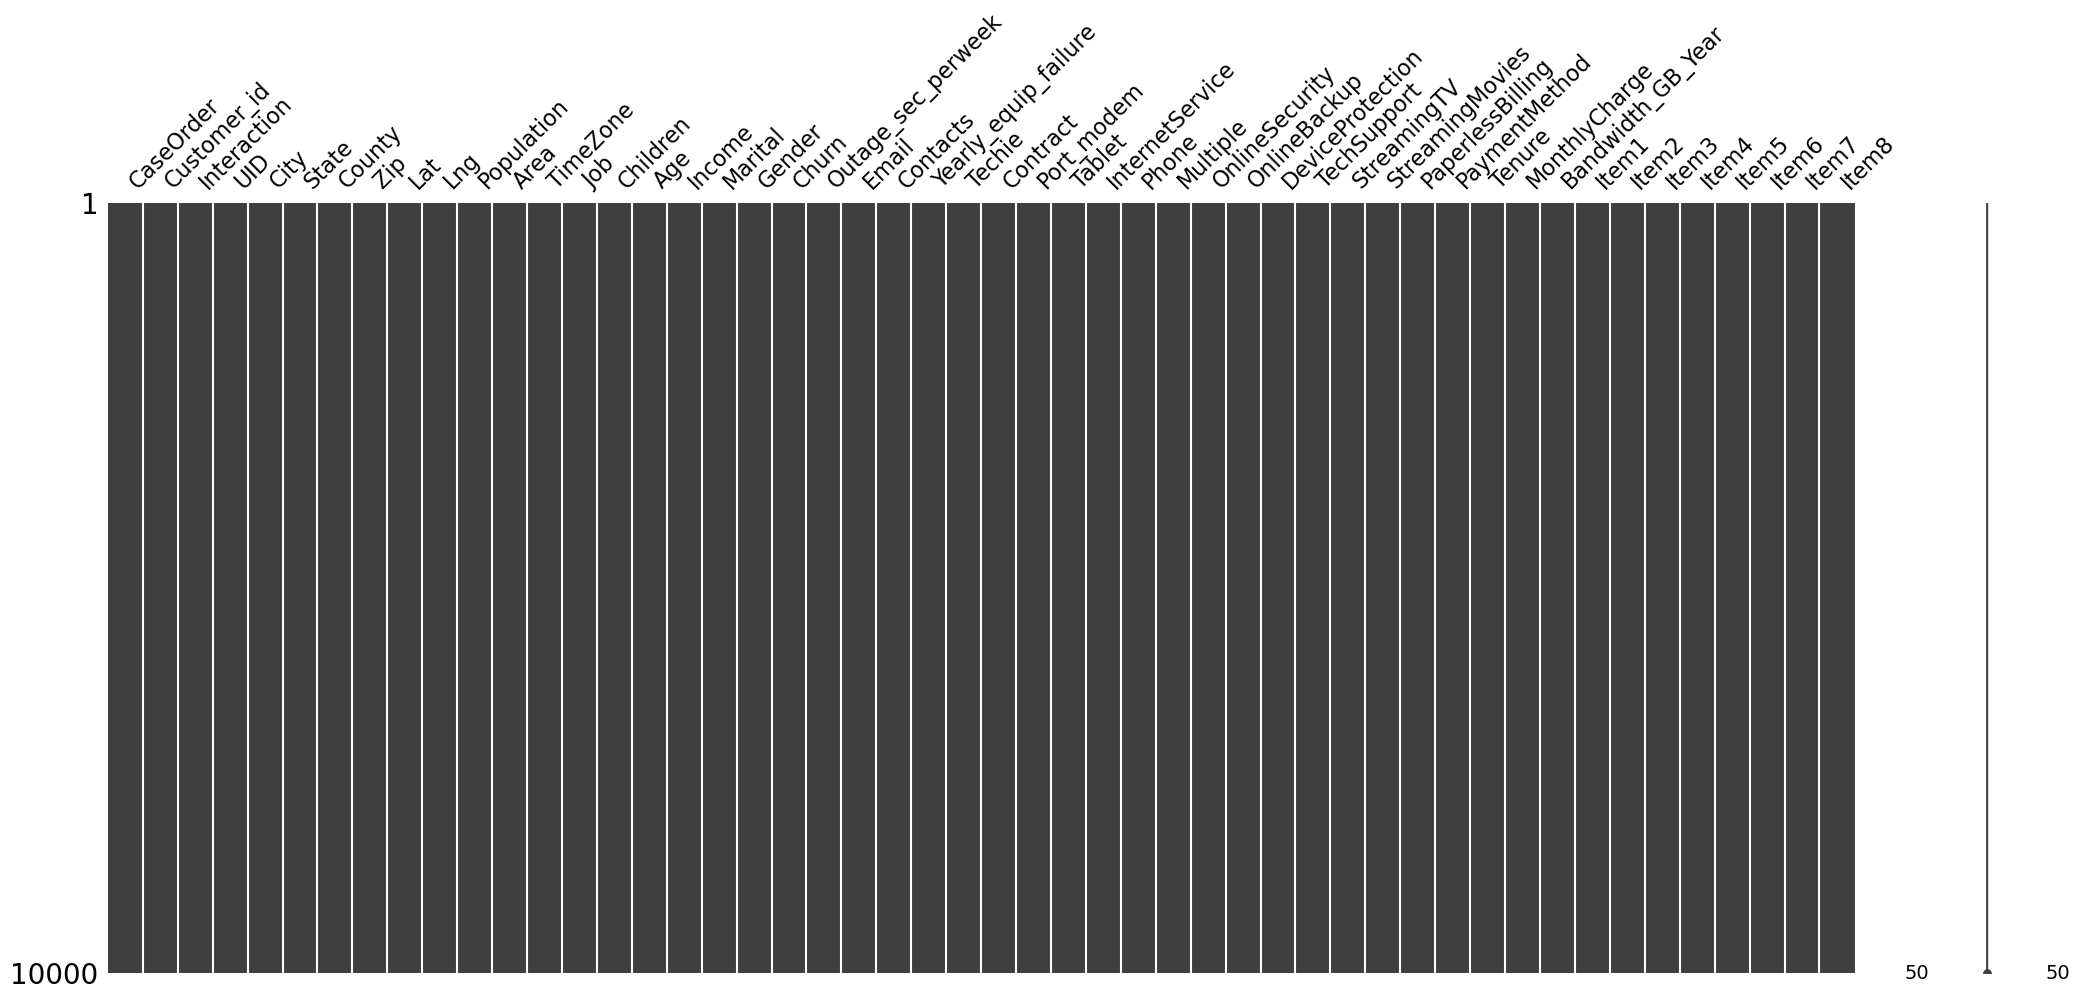

In [2]:
#Part C3 Data Preparation
import pandas as pd
import missingno as msno
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

pd.set_option('display.max_columns', None)

csv = pd.read_csv("churn_clean.csv", keep_default_na=False)
print(csv.describe(), "\n")

#Detect missing values
msno.matrix(csv)

#Detecting duplicate values
print("Complete duplicates:")
print(csv.duplicated().value_counts(), "\n")

#Re-expressing categoricals
categoricals = csv.select_dtypes(include=["object"]).columns
#Drop unneeded columns
categoricals = categoricals.drop(["Customer_id", "Interaction", "UID", "City", "State", "County", "TimeZone", "Job"])

for col in categoricals:
    #encode yes/no values to 1/0
    if csv.at[0, col] == "Yes" or csv.at[0, col] == "No":
        csv[col] = csv[col].map({"Yes" : 1, "No" : 0}).astype('bool')
        categoricals = categoricals.drop([col])
    #one-hot encode everything else
    else:
        csv = pd.concat([csv, pd.get_dummies(csv[col], prefix=col)], axis=1)
        
#drop original columns
csv.drop(columns=categoricals, inplace=True)
csv.drop(columns=csv.select_dtypes('object').columns, inplace=True)
#drop irrelevant columns
csv.drop(columns=["CaseOrder", "Item1", "Item2", "Item3", "Item4", "Item5", "Item6", "Item7", "Item8"], inplace=True)
csv.info()

#determine relevant variables through correlation to bandwidth
#continous correlations
correlations = csv.select_dtypes(exclude='bool').corr()[["Bandwidth_GB_Year"]]
subset = correlations.loc[correlations["Bandwidth_GB_Year"].abs() > 0.05]
print(subset)

#categorical correlations
subset = ["Bandwidth_GB_Year", "Tenure", "MonthlyCharge"]
for col in csv.select_dtypes(include='bool'):
    values = stats.pointbiserialr(csv[col], csv["Bandwidth_GB_Year"])
    if values[1] < 0.05: #significant p value
        subset.append(col)
        print(col, ":", values, "\n")

csv = csv[subset]

csv["Bandwidth_GB_Year"].describe()

In [3]:
#Part C4

csv.to_csv("NCina D209 T2.csv")

In [4]:
#Part D1
#split data 70/30 for training and test sets
seed = 42
X = csv.drop("Bandwidth_GB_Year", axis=1).values
y = csv["Bandwidth_GB_Year"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#save to file
csv_train = pd.DataFrame(X_train)
csv_test = pd.DataFrame(X_test)
csv_train.columns = ['Tenure', 'MonthlyCharge', 'Churn',
       'OnlineSecurity', 'OnlineBackup', 'StreamingTV', 'StreamingMovies',
       'Contract_Two Year', 'InternetService_DSL',
       'InternetService_Fiber Optic', 'InternetService_None']
csv_test.columns = ['Tenure', 'MonthlyCharge', 'Churn',
       'OnlineSecurity', 'OnlineBackup', 'StreamingTV', 'StreamingMovies',
       'Contract_Two Year', 'InternetService_DSL',
       'InternetService_Fiber Optic', 'InternetService_None']
csv_train["Bandwidth_GB_Year"] = y_train
csv_test["Bandwidth_GB_Year"] = y_test

csv_train.to_csv("NCina D209 T2 train.csv")
csv_test.to_csv("NCina D209 T2 test.csv")

In [5]:
#Part D2
#random forest regression

rf = RandomForestRegressor(random_state=seed)

param_dist = {
    'max_depth': stats.randint(1, 5),
    'n_estimators': stats.randint(300, 500),
    'min_samples_leaf': stats.randint(1, 10)
}

#random search to get optimal hyperparameters, computationally expensive so it has commented out for the evaluator
# randomCV = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=50, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
# randomCV.fit(X_train, y_train)
# print(randomCV.best_estimator_)
# y_pred = randomCV.predict(X_test)

#random forest with hyperparameters from the random search CV
rf = RandomForestRegressor(n_estimators=434, max_depth=4, min_samples_leaf=2, random_state=seed)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rmse_test = mean_squared_error(y_test, y_pred)**(1/2)
print("RMSE: ", rmse_test)
print("R Squared: ", rf.score(X_test, y_test))

RMSE:  242.04588100369756
R Squared:  0.9876450410941555
